# <u>Walmart Product Review Analysis <u/>

Final Notebook 

## Business Motivation

2020 has been a hectic year, and it has reinforced the importance of technology across all sectors, perhaps none more so than the retail sector. Walmart's motto and philosophy is "Save Money, Live Better", and in order for Walmart to live up to  that standard , they need to be able to provide the "best" items for their customers based on the customer's wants and needs, both in store and online.

Walmart is known for being the [King of retail stores](https://www.pioneeringminds.com/walmart/) , but this is in large part due to the success of its physical stores. Starting in 2017, Walmart developed a strong initiative to strengthen its online presence. In the first quarter of 2020, amidst the pandemic, Walmart saw a [74% increase in online sales in the first quarter](https://www.supermarketnews.com/retail-financial/walmart-sees-q1-us-comps-jump-10-online-sales-soar-74) as people began working from home and required goods to be delivered directly to their door due to limited access to physical locations.

Due to this newfound need to shop online, customer ratings, reviews and recommendation scores are crucial factors in another customer's decision to purchase an item.
After analyzing customer reviews, using Natural Language Processing, as well as other features such as LDA Topic Modeling and price, I used machine learning to extract key features that lead to a customer recommending or not recommending an item. These features can then be used to guide Walmart's online marketing/product campaigns.
Walmart's marketing team can use my model and its findings to promote particular items that resonate best with customers.

For example, my model determined that comfort and fit tend to drive a customer to recommend an item. If an item does not fit well, then it’s not comfortable and not worth the purchase; however, if an item is true to size and fits well, then it is comfortable and highly recommended. Therefore, Walmart could market items such as "Jeans that are always TRUE TO SIZE" and "New ComFIT (comfortable-fit) products to WFH (work from home)".

# Performance Metric
- F1 score: The harmonic mean of percision and recall. This will give me an overall indication of the model. 
- Model needs to be interpretable. This will allow me see the how the features drive my target, recommended or non recommended. However, I will be using less interpretable models such as Random Forest to compare to the interpretable models such as Logestic Regression. 

# Data
Data was scraped directly from the Walmart webpage. The notebooks for scraping can be found in the [Walmart Scraper](https://github.com/dorjeys3/Walmart_proj/tree/master/Walmart_scraper) folder. 

# Exploratory Data Analysis Techniques and Feature Engineering
- Remove unnecessary characters from continuous variables
- Regex: clean raw text by removing unnecesasry characters introduced from scraping
- Tokenizer: tokenize the raw text (sentences) into words
- Stopwords: remove words that do not add value or much meaning for modeling
- Lemmatizer: reduce words to valid lemma (root words). 
- Latent Dirichlet Allocation (Topic) modeling: statistical modeling to extract abstract topics that can be found in the corpus (collection of all reviews)

In [1]:
# Data Cleaning and analysis packages
import pandas as pd
import numpy as np

import pickle 
# necessary for data visualizations 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from nltk.probability import FreqDist

# NLP packages
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer 

import os
import sys

from sklearn import metrics
#from scipy import stats
#from sklearn.metrics import accuracy_score, classification_report, f1_score
#from sklearn.metrics import plot_confusion_matrix, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

module_path = os.path.abspath(os.path.join('./scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import preprocessing as pp
import models as mod
import visual
import cleaning


The creation of the following data can be found in [Walmart Scraper](https://github.com/dorjeys3/Walmart_proj/tree/master/Walmart_scraper) folder. 

In [2]:
mens_df = pd.read_csv("data/item_review/walmart_mens_reviews.csv", index_col=0)
womens_df = pd.read_csv("data/item_review/walmart_womens_reviews.csv", index_col=0)
boys_df = pd.read_csv("data/item_review/walmart_boys_clothing_reviews.csv", index_col=0)
girls_df = pd.read_csv("data/item_review/walmart_girls_clothing_reviews.csv", index_col=0)

In [3]:
cleaning.drop_duplicates(womens_df, "item_name")
cleaning.drop_duplicates(mens_df, "item_name")
cleaning.drop_duplicates(boys_df, "item_name")
cleaning.drop_duplicates(girls_df, "item_name")

In [4]:
womens_df["section"] = "women's clothing"
mens_df["section"] = "men's clothing"
boys_df["section"] = "boy's clothing"
girls_df["section"]="girl's clothing"

In [5]:
frames = [mens_df, womens_df, boys_df, girls_df]
# I will be working with cleaning_df going forward in this notebook
cleaning_df = pd.concat(frames, ignore_index=True)

In [6]:
print(f"There are {mens_df.shape[0]} men's clothing")
print(f" There are {womens_df.shape[0]} women's clothing")
print(f"There are {boys_df.shape[0]} boys' clothing")
print(f" There are {girls_df.shape[0]} girls' clothing")
print('-'*60)
print("Resulting in 1,225 observations.")

There are 308 men's clothing
 There are 471 women's clothing
There are 154 boys' clothing
 There are 292 girls' clothing
------------------------------------------------------------
Resulting in 1,225 observations.


In [7]:
cleaning_df.head()

,item_name,price,overall_rating,num_rating,recommend,rev_title,rev_date,review_text,rating_stars,section
0,Wrangler Men's Unlined Shirt Jacket,$12.00 $ 12 . 00 $12.00 $ 12 . 00,4.0,7 ratings,80%,['Texas winter ready!'],"November 26, 2020",['I bought this last year and am going to buy ...,['Average Rating: ( 5.0 ) out of 5 stars 7 rat...,men's clothing
1,Wrangler Men's Relaxed Fit Jeans,$12.00 $ 12 . 00 $12.00 $ 12 . 00,4.5,5840 ratings,90%,"['Wrangler is the best.', 'My Favorite Jeans',...","August 5, 2020","['I like wrangler, the pants is exactly for my...",['Average Rating: ( 5.0 ) out of 5 stars 5840 ...,men's clothing
2,Wrangler Big Men's Relaxed Fit Jean,$15.00 $ 15 . 00 $15.00 $ 15 . 00,4.3,3257 ratings,88%,"['Jeans That Fit Just Right', 'Great jeans wou...","September 19, 2020","[""If you like Big Men's style wearing jeans th...",['Average Rating: ( 5.0 ) out of 5 stars 3257 ...,men's clothing
3,Wrangler Men's 5 Star Regular Fit Jean with Flex,$12.00 $ 12 . 00 $12.00 $ 12 . 00,4.5,259 ratings,91%,"['Committed buyer', 'More Comfortable than Swe...","January 6, 2020",['My husband loves these jeans and goes throug...,['Average Rating: ( 5.0 ) out of 5 stars 259 r...,men's clothing
4,Wrangler Men's and Big Men's 5 Star Relaxed Fi...,$15.00 $ 15 . 00 $15.00 $ 15 . 00,4.6,1490 ratings,91%,['Saved money and faster delivery that Amazon'...,"November 1, 2020",['Fit well Great price same jeans I was buying...,['Average Rating: ( 5.0 ) out of 5 stars 1490 ...,men's clothing


## Null values
There are null values in all features, except num_rating and section. 
- "Rev_date" is not a helpful column, so will drop that column entirely. 
- In order to declare which items will do well and wont, I will need name of the item. Thus I will drop the two items
- I will need to look more into "overall_rating" and "recommend"
- rating starts will probably changed to 0. but will need to look more into it.

Regarding the text, the EDA will be done in the next notebook. 
- Where there is no "rev_title", I will add "No Title". This is only for EDA purpose. 
- I will need to look more closly into the review_text before dropping any rows. 
 

In [8]:
# droppping rev_date as mentioned above
cleaning_df.drop(columns = "rev_date", inplace = True)
# droppping item_name as mentioned above
cleaning_df.dropna(subset=["item_name"], axis = 0, how="any", inplace=True)
# Since we already have an overall raiting of the item, I will be removing the "rating_star" column. 
cleaning_df.drop(columns="rating_stars", inplace = True)

If overall rating was null, then it was changed to 0. The same conditions were used for recommened.
The scraper function included a condition that if it had no "See all reviews" - meaning that the item did not have an rating or reviews. **However, if it does contain a rating but no review text, the item was still scraped.**

In [9]:
# if recommended score is null, then it is replcaed by a 0. I did not want to interject my own bias by scoring the item. 
cleaning_df["recommend"].fillna(0, inplace = True)
# The review titles are not helpful and do not really add much to the scope of the project. Therefore will be dropping it.
cleaning_df.drop(columns = "rev_title", inplace = True)

After taking care of all the missing values and removing features that do not add to the project, I can now proceed to clean the continuous values. 

In [10]:
# function can be found in the cleaning.py file located in scripts folder. 
# Convertor fuction converts srtings into a list and return index 0
cleaning_df["price"] = cleaning_df["price"].apply(cleaning.convertor)
cleaning_df["num_rating"] = cleaning_df["num_rating"].apply(cleaning.convertor)

In [11]:
# function can be found in the cleaning.py file located in scripts folder. 
# remove_dollar function removes the '$' from the price 
cleaning_df["price"]= cleaning_df["price"].apply(cleaning.remove_dollar)

In [12]:
# correcting the data type ("dtype") of each column. 
# currently dtype for the columns below is "object". 
cleaning_df["num_rating"]=cleaning_df["num_rating"].astype("float64")
cleaning_df["price"]=cleaning_df["price"].astype("float64")
cleaning_df["recommend"]=cleaning_df["recommend"].astype("string")

In [13]:
# function can be found in the cleaning.py file located in scripts folder. 
# remove_perc function removes the "%" from the string
cleaning_df["recommend"]= cleaning_df["recommend"].apply(cleaning.remove_perc)
# after removing the '%' converting dtype to float type. 
cleaning_df["recommend"]=cleaning_df["recommend"].astype("float64")

In [14]:
cleaning_df.head()

,item_name,price,overall_rating,num_rating,recommend,review_text,section
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['I bought this last year and am going to buy ...,men's clothing
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['I like wrangler, the pants is exactly for my...",men's clothing
2,Wrangler Big Men's Relaxed Fit Jean,15.0,4.3,3257.0,88.0,"[""If you like Big Men's style wearing jeans th...",men's clothing
3,Wrangler Men's 5 Star Regular Fit Jean with Flex,12.0,4.5,259.0,91.0,['My husband loves these jeans and goes throug...,men's clothing
4,Wrangler Men's and Big Men's 5 Star Relaxed Fi...,15.0,4.6,1490.0,91.0,['Fit well Great price same jeans I was buying...,men's clothing


This looks a lot neater and easier to process. 

I now inspect the missing values in the raw "review_text" column since this is the core of this project. 

In [15]:
nan_rows = cleaning_df[cleaning_df["review_text"].isnull()]
nans = nan_rows.section.value_counts()

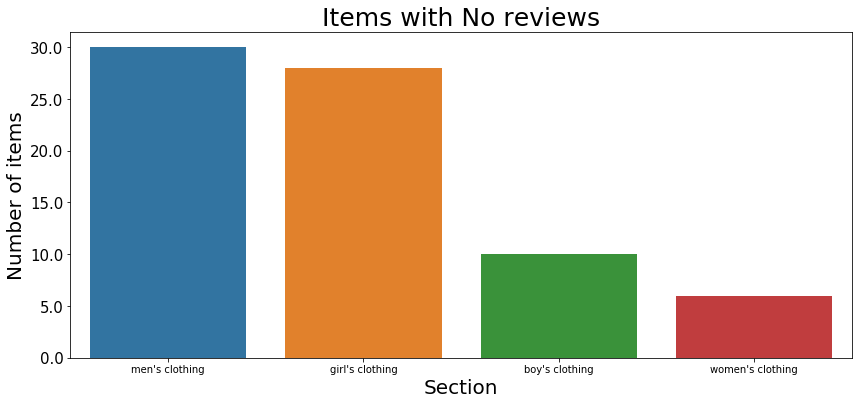

In [16]:
visual.bar_plot(nans.index, nans.values, title="Items with No reviews",
                x_label="Section", y_label="Number of items")

- These are all the observations that have a rating score but no reviews. 
- Women's clothing group has the most items/observations and also the least amount of non-reviewd items. 
- Surprisingly, men's clothing and girls' clothing have a large amount of observations without reviews. 
 I will be dropping the null values in review_text. If I fill in the null values, it will cause bias and/or add unnecessary data. 

In [17]:
cleaning_df.dropna(subset=["review_text"], inplace = True)

In [18]:
# function can be found in the cleaning.py file located in scripts folder. 
# bin_target funciton bins the recommended score of 0-100 into recommended or not recommened on a hard split of 83.
# 83 was the average score. The central tendency can be found notebook 1. 
cleaning.bin_target(cleaning_df, "recommend")

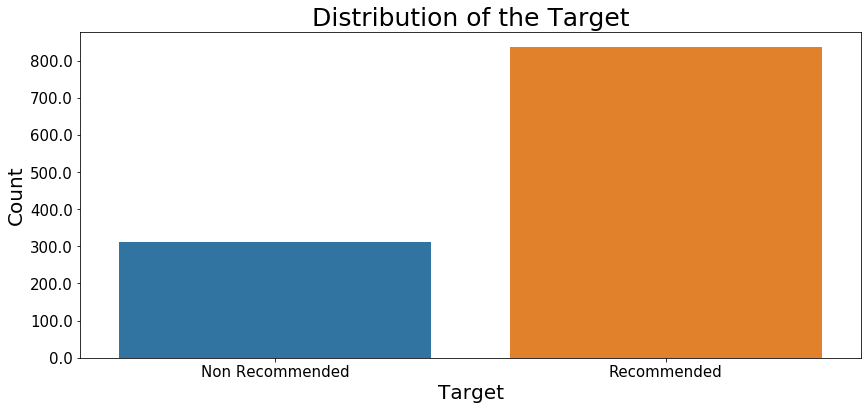

In [19]:
visual.count_plot(cleaning_df, "target",
                 title = "Distribution of the Target",
                 x_label="Target", y_label="Count", tick_labels = ["Non Recommended", "Recommended"])

There is a class imbalance in my target group. The "recommended" group is greater than 2 times the size of "not recommended". This could lead my model to predict most items as recommended item. 

I will need to consider how to deal with that before I start my modeling process. One method is to try class_weight = 'balanced' in the models. Another would be to use SMOTE. However, this is a little ticky since we are processing Natural Language and 

In [20]:
cleaning.bin_rating(cleaning_df, "overall_rating")

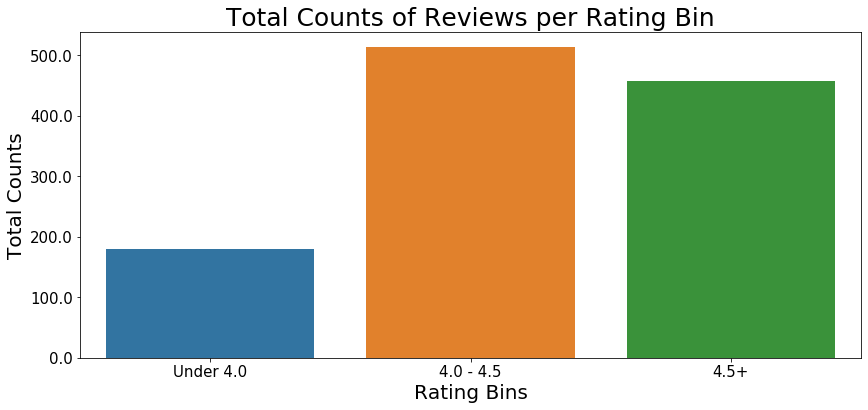

In [21]:
visual.count_plot(cleaning_df, "rating_bin", title="Total Counts of Reviews per Rating Bin",
           x_label = "Rating Bins", y_label = "Total Counts", tick_labels=["Under 4.0", "4.0 - 4.5", "4.5+"])

I would say this binning method is fairly balanced and reflects the datatset well since most products do not get low ratings. 



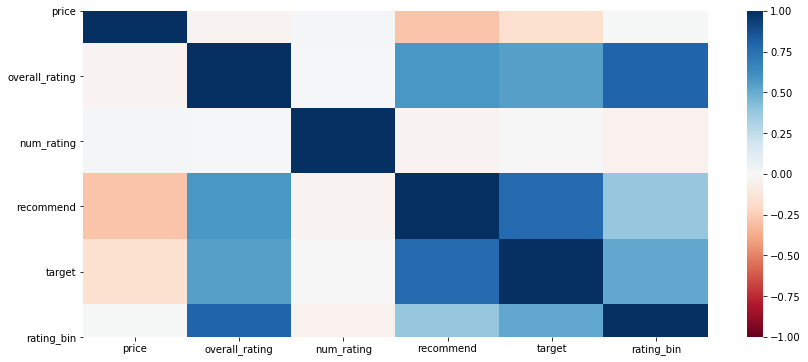

In [22]:
visual.corr_plot(cleaning_df)

The heatmap shows that there are no correlation between price and other continuous features. However, Walmart is known for their low prices, so it would be interesting to see how the price is spread between the two target variables. This visual analysis and interpretation can be found in [notebook1](https://github.com/dorjeys3/Walmart_proj). 

The strongest correlation is between overall_rating and recommended score. I am interested in seeing the spread across the four sections that I scraped. 

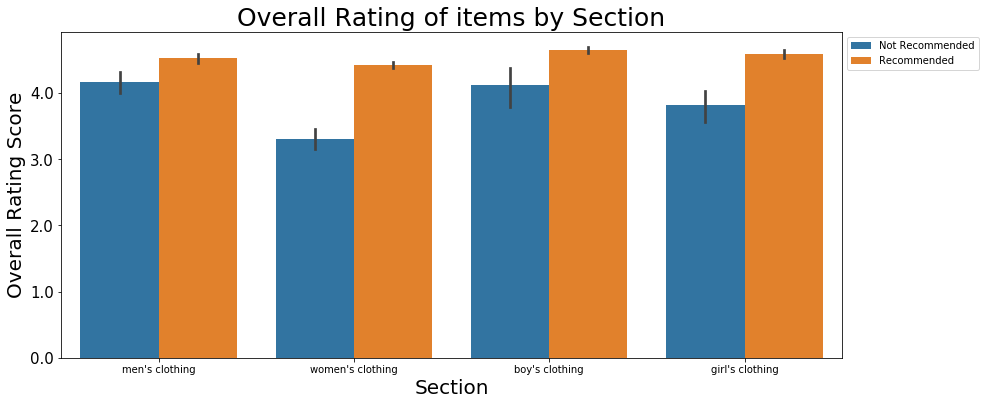

In [23]:
visual.bar_plot("section", "overall_rating", cleaning_df, 
        hue="target", title="Overall Rating of items by Section",
        x_label="Section", y_label="Overall Rating Score")
L=plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('Not Recommended')
L.get_texts()[1].set_text('Recommended')

- As illustrated by the the heatmap, as overall rating score incresaes, so does the chance of item being recommended. This seems like logic, but this means that the binning of the recommended score works. 
- During the scraping, I did notice that women's clothing tend to have more reviews and the sentiment is generally positive for an item. However, due to one or two features of a product, the items would not be recommeneded. This is something I will need to look more into in the next notebook

### Preprocessing Steps
From this point on, for any necessary clarifications, please check notebook 2_preprocessing_walmart_product_review_nlp first. 

In notebook1, I save cleaning_df as clean_df for preprocessing. In this notebook, all data cleaning and preprocessing, EDA and feature engineering will be conducted on cleaning_df. 

In [24]:
# making a new column and applying the clean_text function on the review text.
# clean_text funciton will filter for only english alphabets (a-z and A-Z) and return words in lower case. 
cleaning_df["clean_review_text"] = cleaning_df["review_text"].apply(pp.clean_text)

# All text is now clean and ready to be used for feature engineering. 
Preprocessing steps:
- Tokenizer: tokenize the raw text (sentences) into words
- Stopwords: remove words that do not add value or much meaning for modeling
- Lemmatizer: reduce words to valid lemma (root words). 
- Latent Dirichlet Allocation (Topic) modeling: statistical modeling to extract abstract topics that can be found in the corpus (collection of all reviews)

In [25]:
# creates a new column using the tokenize function - splits sentences into words
cleaning_df["tokenized"] = cleaning_df.clean_review_text.apply(pp.tokenize)
# creating a new column with remove_stopwords function - removes words that do not add value
cleaning_df["rem_stop"] = cleaning_df.tokenized.apply(pp.remove_stopwords)
# creating a new column with lemmatize_text function - reduces words to its root. 
cleaning_df["lemma_words"] = cleaning_df.rem_stop.apply(pp.lemmatize_text)

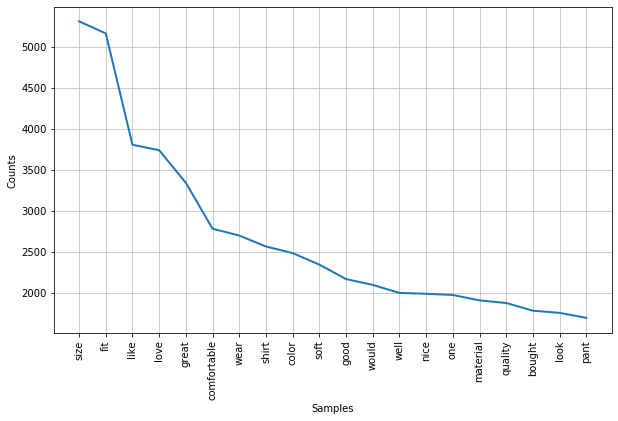

Number of words in corpus: 9083


In [26]:
visual.fdist(cleaning_df, "lemma_words")

Size and fit seem to be very important and constantly refered to based on the FreqDist. However, these words appear in both recommended and non recommended words. This will decrease the sensitivity of my model. Therfore will need to add it to stopwords. However, this is something to keep in mind since size and fit are highly talked about in the reviews. 

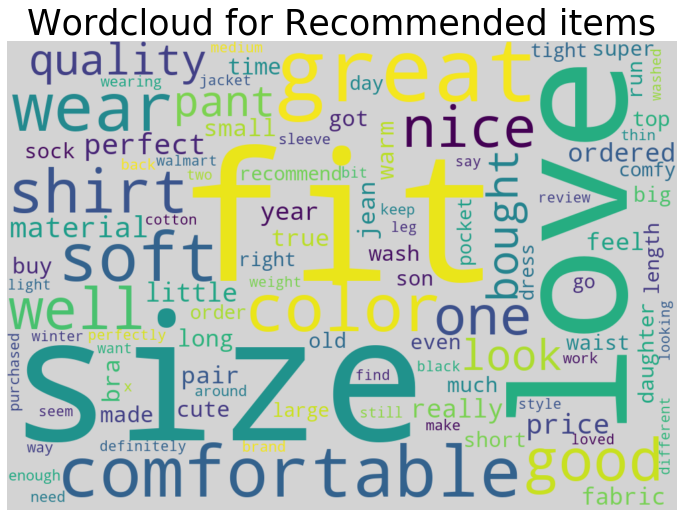

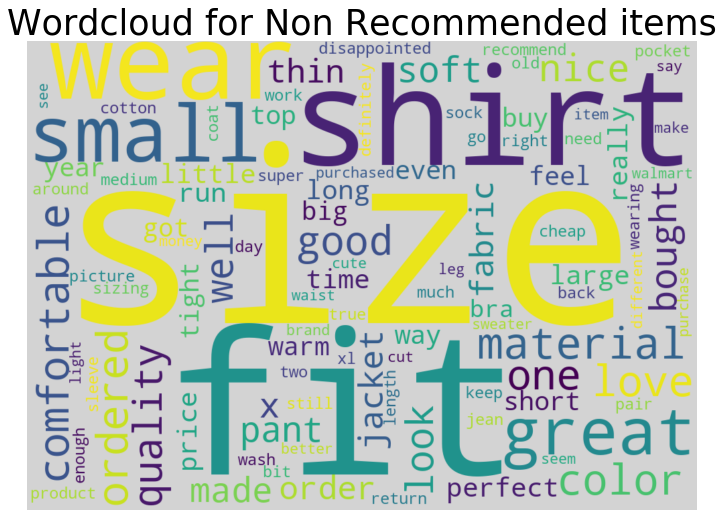

In [27]:
visual.pos_cloud(cleaning_df, "target")
visual.neg_cloud(cleaning_df, "target")

In [28]:
# remove_eda_stopwords function removes the added stopwords from the word cloud and eda.
cleaning_df["lemma_words"] = cleaning_df["lemma_words"].apply(pp.remove_eda_stopwords)

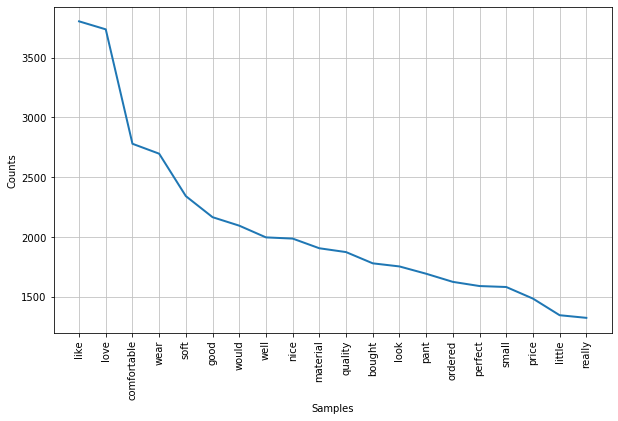

Number of words in corpus: 9031


In [29]:
# confirming size and fit have been removed. 
visual.fdist(cleaning_df, "lemma_words")

In [30]:
# list_to_string function will convert the list into a string. This is necessary to create LDA topic modeling
cleaning_df["delisted"] = cleaning_df["lemma_words"].apply(pp.list_to_str)

#### LDA (Topic) Model
 
The reason for creating a topic model is to see if there are words that can be grouped together. I hypothesize that there will be no luck with finding good topic models but its worth the try. The algorithm might find something that I missed in my eda. The code to generate LDA model lives in notebook 2_processing_walmart_product_review. 

In [31]:
#importing lda from notebook 2
filename = "pickle_jar/lda.pkl"
infile = open(filename,"rb")
lda = pickle.load(infile)
infile.close()

In [32]:
lda.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,0.011115,0.011115,0.011115,0.122070,0.011115,0.011115,0.789009,0.011115,0.011115,0.011115
1,0.000000,0.000000,0.000000,0.010731,0.000000,0.000000,0.987497,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.023174,0.000000,0.000000,0.974768,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.021575,0.000000,0.000000,0.974928,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.023940,0.000000,0.000000,0.973633,0.000000,0.000000,0.000000


The statistical scores that are generated from LDA Topic modeling simply state how "fitting" a document is with this set of topics. For example, review text from row 0 "fits" in all topics but rows 1-4 only fit in topic 3 and topic 6. 

Topic 6 includes words such as the following in the importance from left to right: 
"mistake", "worth", "grateful", "supposed", "seen", "chose", "present", "half", "puffy" and "pre". 

Topic: 3 includes words such as the following in the importance from left to right: 
"gilet", "pannier", "stay", "em", "bootcut", "significant", "incident", "watch", "brief" and "flare", 

When you compare topic 3 and topic 6 scores, we see that topic 6 is higher and therefore more "fitting" for documents in row 1-4. 

In general, Topic 6 seems to be dominating the dataframe. This may be because customers are describing how either their puchase was a "mistake" or how an item was "worth" the price. This is something I will need to take into consideration in the modeling notebook. However, the words are not unique enough for me to classifiy and give it a topic title.

Before we dive into modeling, we need to take something into consideration. We saw that *fit* and *size* were crucial in both recommended and non recommended items. This is something to keep in mind because this might help explain features that will be extracted from modeling. 

# Final Models and Interpretation

In [33]:
# cleaning_df merged with the LDA topic dataframe. 
filename = "data/modeling_df.pkl"

infile = open(filename,"rb")
df = pickle.load(infile)
infile.close()

The dataframe "df" is the the final model that includes the cleaned dataframe from data cleaning and preprocessing merged with the LDA topic scores.  

In [34]:
df.head(2)

,item_name,price,overall_rating,num_rating,recommend,review_text,section,target,rating_bin,clean_review_text,...,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['I bought this last year and am going to buy ...,men's clothing,0,1,i bought this last year and am going to buy an...,...,0.011115,0.011115,0.011115,0.122070,0.011115,0.011115,0.789009,0.011115,0.011115,0.011115
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['I like wrangler, the pants is exactly for my...",men's clothing,1,1,i like wrangler the pants is exactly for my bo...,...,0.000000,0.000000,0.000000,0.010731,0.000000,0.000000,0.987497,0.000000,0.000000,0.000000


# Train Test Split

Dropping the following features:
- item name is just a unique identifier so its not useful. 
- review text, clean review text, rem_stop, tokenized, lemma_words are basically the same and TFIDF was generated form these features. 
- overall_rating, rating_bin and recommend features are highly correlated with the target, which would hurt the models in estimating the relationship between the feautres and target.  


Now that we have cleaned the continuous variables, tokenized the raw text, removed stopwords, lemmatized words to their roots and generated LDA Topic scores. 

In [35]:
drop_features = ["item_name", "overall_rating", "rating_bin", "recommend", 
                 "clean_review_text", "review_text", "section", "tokenized", "rem_stop", "lemma_words", 
                 "target"]

In [36]:
X = df.drop(columns = drop_features)
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# TFIDFVectorizer

TF-IDF stands for Term Frequency-Inverse Document Frequency, which provides a frequency score to highlight words that are more frequent in one document but not across all documents. 

I use TfidfVectorizer to find important and unique words for each document when compared to the rest of the documents. 

I initialize the TfidfVectorizer on the delisted column, fit transform the X_train, and transform the X_test. Since the TfidfVecotrizer produces a spare matrix, I changed the spare matrix into a dataframe and merged it with the original X_train and X_test. 

The added stopwords from the EDA in notebook 2 should have already removed the stopwords, but having this here was just as a backup for the Count Vectorizer and Tfidf Vectorizer. 

In [37]:
# Extracted the stopwords from my preprocessing notebook to be used for the TfidfVectorizer
eda_stopwords = ["nd", "de", "u", "la", "tbw", "c", "v", "great", "n", "wal", "wow","hi", "hello",
                 "nmbc", "youll", "must", "said", "either", "lol", 'ill', "six", "goat", "thou", 
                 "un", "lb", "pair", "right", "x", "xl", "one", "way", "definitely", "shirt", 
                 "jacket", "jean", "daughter", "son"]

stop_words=list(set(stopwords.words("english")))

stop_words.extend(eda_stopwords)

In [38]:
tfidfvec = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,2), max_features=2000, use_idf=True)  

train_vec = tfidfvec.fit_transform(X_train.delisted.values).toarray()
test_vec = tfidfvec.transform(X_test.delisted.values).toarray()

tfidf_train = pd.DataFrame(train_vec, columns = tfidfvec.get_feature_names())
tfidf_test = pd.DataFrame(test_vec, columns = tfidfvec.get_feature_names())

print(f"X train shape: {X_train.shape}, Tfidf train shape: {tfidf_train.shape}") 
print("-"*20)
print(f"X test shape: {X_test.shape}, Tfidf test shape: {tfidf_test.shape}")

# resetting index to concatenate with tfidf. Resetting index will not affect the dataset. 
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

frame1 = [X_train, tfidf_train]
frame2 = [X_test, tfidf_test]

X_train = pd.concat(frame1, axis=1)
X_test = pd.concat(frame2, axis=1)

X train shape: (919, 16), Tfidf train shape: (919, 2000)
--------------------
X test shape: (230, 16), Tfidf test shape: (230, 2000)


Since the TfidfVector was generated from the delisted column, this feautre had to be dropped. 

In [39]:
X_train.drop(columns = ["delisted"], inplace = True)
X_test.drop(columns = "delisted", inplace=True)

# Best Models

After interating the modesl, here is what I found:


| Model | F1 Score |
|:-|:-|
| Dummy Classifier F1 score | 0.757 |
|Logistic Regression Baseline F1 score | 0.864|
|Logistic Regression 2.0 F1 score is: |0.836|
|GridSearchCV w/ Logistic Regression F1 score is:| 0.838|
|Logistic Regression 3.0 F1 score is:| 0.838|
|BernoulliNB Baseline F1 score is:| 0.863|
|BernoulliNB 2.0 F1 score is:| 0.854|
|SVC Baseline F1 score is:| 0.861|
|SVC 2.0 F1 score is:| 0.837|
|GridSearchCV w/ Support Vector Classifier F1 score is:| 0.863|
|Random Forest Baseline F1 score is:| 0.879|
|Random Forest 2.0 F1 score is:| 0.878|
|GridSearchCV w/ Random Forest F1 score is:| 0.883|
|GridSearchCV w/ Random Forest 2.0 F1 score is:| 0.880|
|Random Forest 3.0 F1 score is:| 0.878|

All models perform better than the Dummy Classifier, which was to be expected. However, due to the class imbalance, the parameters needed to be tuned. The baseline models do not have any parameters. The first iteration of the models only had the class_wegith = "balanced". Finally, the models were then tuned and cross validated. 

The best performing models were:

|Models|F1 Scores|
|:-|:-|
|GridSearch Logistic|0.838906  |
|GridSearch RandomForest|0.880223|


# Dummy Classifier

Evaluation Metrics:
Accuracy: 0.6869565217391305
Precision: 0.8035714285714286
Recall: 0.7758620689655172
F1: 0.7894736842105263
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.70967742 0.7480916  0.72463768 0.7518797  0.703125   0.6875
 0.70769231 0.74626866 0.69767442 0.75555556]
Mean F1 Scores:  0.72321
Standard Deviation: 0.02403
------------------------------------------------------------


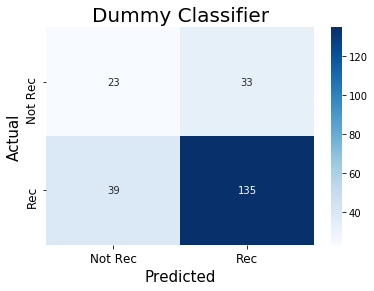

In [40]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
y_preds_dum = dummy_clf.predict(X_test)
print(mod.model_metrics(y_test, y_preds_dum));                 
print("-"*60)
mod.cross_validation(dummy_clf, X_train, y_train, cv=10)
print("-"*60)
mod.con_mat(y_test, y_preds_dum, title="Dummy Classifier")

Accuracy for dummy is a bit higher than expected (expected to be near 50%). Additionally, there is a good amount of False Negative and False positive in the confusion matrix. This might be due to the class imbalance. Mean F1 score of 0.713 can also be explained due to the class imbalance.

I used class_weight="balanced" to combat this. 

# Logistic Regression

Evaluation Metrics:
Accuracy: 0.7478260869565218
Precision: 0.8866666666666667
Recall: 0.764367816091954
F1: 0.8209876543209876
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.784      0.80645161 0.80327869 0.76033058 0.82352941 0.83969466
 0.79032258 0.84615385 0.88188976 0.784     ]
Mean F1 Scores:  0.81197
Standard Deviation: 0.0343
------------------------------------------------------------


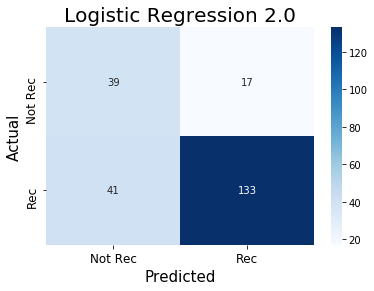

In [41]:
logreg_clf2 = LogisticRegression(random_state = 0,n_jobs=-1, class_weight="balanced")
logreg_clf2.fit(X_train, y_train)
y_pred_lr2 = logreg_clf2.predict(X_test)
print(mod.model_metrics(y_test, y_pred_lr2))
print("-"*60)
mod.cross_validation(logreg_clf2, X_train, y_train)
print("-"*60)
mod.con_mat(y_test, y_pred_lr2, title="Logistic Regression 2.0")

F1 score was at 0.795 after balancing the class weight, the recall dropped by 0.15 and False Negative also increased when compared to the baseline. This means that when it's actually "recommended", our model predict correctly 79%% of the time. The Model predicted 79 items as not recommened items, when only 56 items are actual not recommended items. Out of 79 items, 41 were predicted correctly, which is higher than Baseline Logistic Regression model and the dummy classifier. Therefore, actual Non Recommended items were predicted correctly at a higher rate. Since, Walmart has a ton of items, falsly predicting some recommended items as not recommended does not hurt drastically. We still have a decent precision rate at 0.90. Precision rate is calucated by answering, When model predicted "Recommended", how often is it correct? So, predicting corretly at 90% is still a win.  

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 732 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   53.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


------------------------------------------------------------
{'C': 3, 'penalty': 'l2', 'tol': 8}
------------------------------------------------------------
Evaluation Metrics:
Accuracy: 0.7260869565217392
Precision: 0.8881118881118881
Recall: 0.7298850574712644
F1: 0.8012618296529969
None
------------------------------------------------------------


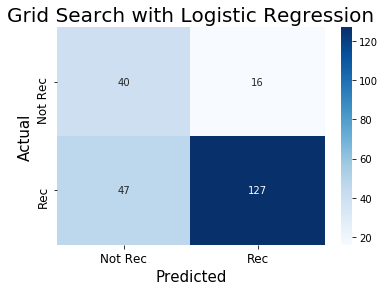

In [42]:
logreg = LogisticRegression(random_state = 0, n_jobs=-1, verbose=2, class_weight="balanced")
log_dict = {'tol': range(1,9,1), 'C': range(3,8), 'penalty': ["l1", "l2"]}
grid_log = GridSearchCV(logreg, log_dict, cv=10, scoring="f1", verbose=2, n_jobs=-1)
grid_log.fit(X_train, y_train)
print("-"*60)
print(grid_log.best_params_)
print("-"*60)
grid_log_pred = grid_log.predict(X_test)
print(mod.model_metrics(y_test, grid_log_pred))
print("-"*60)
mod.con_mat(y_test, grid_log_pred, title="Grid Search with Logistic Regression")

F1 score went up to 0.837, which is an increase of 0.032 using the best parameters. The accuracy of the model is the same as the model above and we still have a decent precision rate at 0.89 (predicting corretly at 89%). The True Negative decreased a by 2 items but the True Positive increased by 2. 


# Random Forest with Tuning

------------------------------------------------------------
Evaluation Metrics:
Accuracy: 0.808695652173913
Precision: 0.8095238095238095
Recall: 0.9770114942528736
F1: 0.8854166666666666
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.85526316 0.81879195 0.84615385 0.8590604  0.84415584 0.87837838
 0.84563758 0.84415584 0.86666667 0.86666667]
Mean F1 Scores:  0.85249
Standard Deviation: 0.01576
------------------------------------------------------------


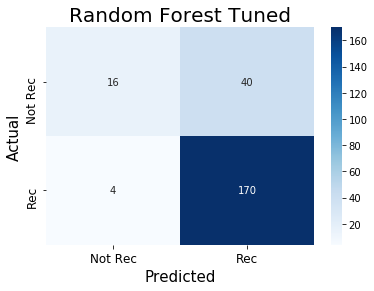

In [43]:
rfc_classifier2 = RandomForestClassifier(n_estimators = 300, criterion = "entropy", random_state = 0, class_weight="balanced")
rfc_classifier2.fit(X_train, y_train)
y_pred_RF2 = rfc_classifier2.predict(X_test)
print("-"*60)
print(mod.model_metrics(y_test, y_pred_RF2))
print("-"*60)
mod.cross_validation(rfc_classifier2, X_train, y_train, cv=10)
print("-"*60)
mod.con_mat(y_test, y_pred_RF2, title="Random Forest Tuned")

Light tuning of the Random Forest Model did not help much. We have a decent F1 score but that is due to the high recall score. Since most items are recommended items, it would predict correctly more often than not. GridSeachCV with Random Forest should help us select the best parameters. 

# GridSearchCV with Random Forest Classifier

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0

------------------------------------------------------------
Evaluation Metrics:
Accuracy: 0.8304347826086956
Precision: 0.8688524590163934
Recall: 0.9137931034482759
F1: 0.8907563025210085
None
------------------------------------------------------------


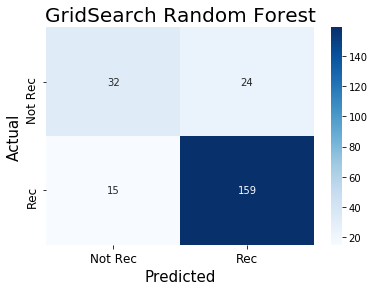

------------------------------------------------------------
{'max_depth': 3, 'max_leaf_nodes': 6, 'min_samples_leaf': 4}
------------------------------------------------------------
The best performing hyperparameters for GridSeachCV using Random Forest is the following: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, max_leaf_nodes=6, min_samples_leaf=4,
                       n_estimators=300, n_jobs=-1, random_state=0, verbose=1). Resulting in a F1 score of 0.8907563025210085


In [44]:
rfc = RandomForestClassifier(n_estimators = 300, criterion = "entropy",
                             random_state = 0, verbose=1, n_jobs=-1, class_weight="balanced")

param_dict={'min_samples_leaf':range(1,10,1), 'max_depth': range(1,10,1), "max_leaf_nodes":range(5,11,1)}

grid_tree = GridSearchCV(rfc, param_dict, cv=5, scoring="f1", verbose=2, n_jobs=-1)
grid_tree.fit(X_train, y_train)

grid_tree_pred = grid_tree.predict(X_test)

print("-"*60)
print(mod.model_metrics(y_test, grid_tree_pred))
print("-"*60)
mod.con_mat(y_test, grid_tree_pred, title="GridSearch Random Forest")

print("-"*60)
print(grid_tree.best_params_)
print("-"*60)
print(f"The best performing hyperparameters for GridSeachCV using Random Forest is the following: {grid_tree.best_estimator_}. Resulting in a F1 score of {metrics.f1_score(y_test, grid_tree_pred)}")

Initially, the Random Forest with class_weight = "balance" did not seem effective. The confusion matrix demonstrated not enough True Negatives being selected like Logistic Regression. However, in the GridSeachCV with Random Forest, the additional parameters did really well to indentify some of the True Negatives. 

The optimal parameters selected by GridSearch increased the overall F1 score and precision rate. It also does a better job classifing the True Negative and True Positives.

Nonetheless, since the range for the max_leaf_nodes ends at 10 and the best parameter is said to be 10, I need to increase the range to investigate what the optimal max_leaf_nodes is. 

After I ran the second iteration, the True Negative and True Positives decreased. Therefore, this is the best Random Forest Parameters. 

# Feature Importances

### Feature Importance from Logistic Regression

In [45]:
log_reg_coef=pd.DataFrame(mod.get_coef_name(logreg_clf2, X_train), columns = ["coefficient", "feature"])

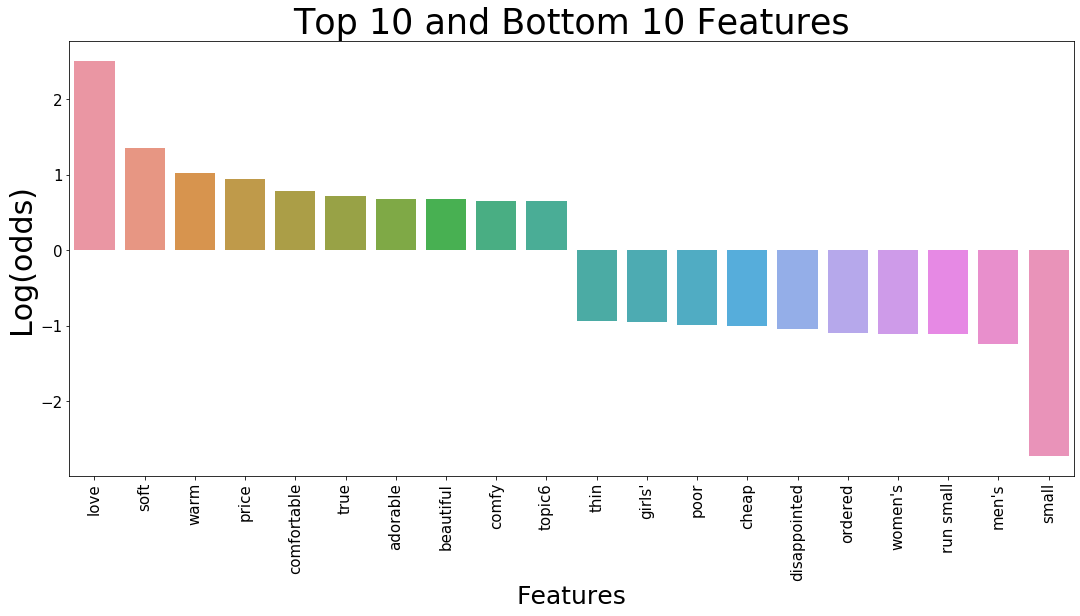

In [46]:
top5_coef = pd.concat([log_reg_coef.head(10),log_reg_coef.tail(10)])
fig, ax = plt.subplots(figsize = (18,8))
sns.barplot(x = top5_coef.feature, y=top5_coef.coefficient)
plt.title("Top 10 and Bottom 10 Features", fontsize=35)
plt.xlabel("Features", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=90)
plt.ylabel("Log(odds)", fontsize=30);

Features that seem to drive recommending items the greatest are words like love, soft, ture (to) size, true, warm, comfy. These make a lot of sense since customer would love items that fit them properly, is comfortable and looks beautiful and adorable. 
However, if the items are cheaply made or does not fit properly then items are not recommended. Interestingly, we did see the words Fit and Size to be the most occuring words in the frequency distributionm, which can be found in notebook2. 

Just from this feature importance, we can conclude that Fit, size and quality are to be the main things that customers really want in their item. We should check how customers use these words in the review text. But first, we should analyze the feautre importance from the GridSearchCV with Random Forest.  

### Feature Importance from Random Forest

In [47]:
grid_tree_feats=pd.DataFrame(mod.get_feats_name(grid_tree, X_train), columns = ["importance", "feature"])

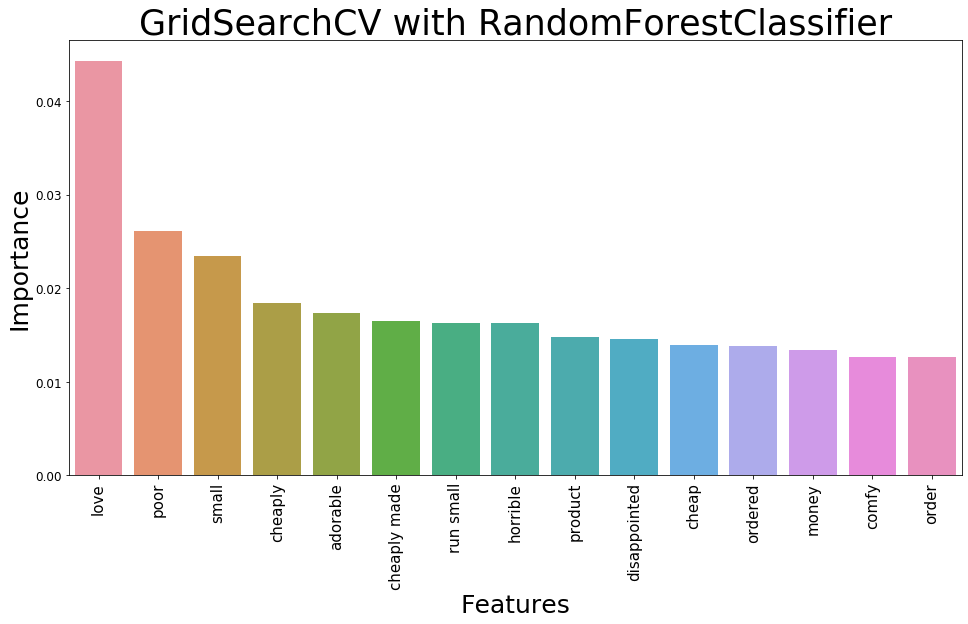

In [48]:
top_grid_feats =grid_tree_feats.head(15)
fig, ax = plt.subplots(figsize = (16,8))
sns.barplot(x = top_grid_feats.feature, y=top_grid_feats.importance)
plt.title("GridSearchCV with RandomForestClassifier", fontsize=35)
plt.xlabel("Features", fontsize=25)
ax.tick_params(labelrotation=90, axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=12)
plt.ylabel("Importance", fontsize=25);

Random Forest does not show the direction of how these features affect the target, recommeneded or not recommended items. However, we do see the weight these features hold. Interestingly, they are mostly the same features selected by the Logistic Regression. 

# Conclusion

My models produced a decent F1 score and the features extracted from the Logistic Regression and GridSearchCV with RandomForest Classifier support each other. 

**Therefore, Walmart could market items such as "Jeans that are always TRUE TO SIZE" and "New ComFIT (comfortable-fit) products to WFH (work from home)".**

If items fit well, then it is often recommended. Additionally, a proper fit is also "comfortable" and my analysis found that "comfort" drives recommendation.  Whereas, Customer's having to return products due to sizing issues seem to push items to being non-recommended. 

One way to tackle this would to be do additional research and tests on the partner brands to see how ture to size their products are. 

Additionally, it seems like quality control needs to be addressed. 

* "When we opened the vacuum sealed packaging that this Mario suit came in, we were completely overwhelmed by a smell of mold and mildew."
* "First, the sweater came smelling really bad like vinegar. Worst of all, the design came off after just one wash!"

Walmart partners with brands, large and small, and sells their items online. However, when items are received by the customers in bad condition, Walmart receives the blame causing their public image to be degraded. 


## Next Steps


During this analysis, I discovered that Brand's would get compared to each other in the reviews. I found multiple instances wherer this occurs but I could only find one again to demostrate as example: An inner wear item, Disney Junior Toddler Girls Sofia the First, was compared to Fruit of The Loom.


* "Seams are starting to unravel after first use. Spend the extra money on Hanes brand or Fruit of a Loom..so disappointed..."

Another place I would like to spend more time is exploring whether lemmatize or stemming should even be considered. For instance, "Slip" was lemmatized from Slippers, slippery, slips, slipping. Slip was being refered correctly at itmes, where customers were talking about how the elastic does not perform well and causes the pants to slip and the item was not recommended. And other times, it was lemmatized from slippers


* "Hubby also claims they slip down easily if not tied tightly."

* "I sadly had to return my ballet slipper because I ordered the wrong size."